## Throwback: which SNPs are associated with mouse coat color?

This is the final notebook. It's a tiny excercise to revisit an older analysis with a new approach.

Remember the GWAS task from day 3, where we investigated which SNPs were associated with the black coat color of mice? Back then, we found them with methodical statistical testing. This time we'll find them with the help of random forests.

We know random forests are useful to determine the importance of different features for classifying samples. Therefore we could train a random forest to predict hair color from genotype data, and then look at what features it considered important while doing it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

Load the genotype and color data.

In [2]:
genotype = pd.read_csv("../example_data/aad0189_DataFileS4.txt", sep="\t", comment="@", index_col="Locus")
colors = pd.read_csv("../example_data/coat_color.csv", index_col=0, names=["color"], na_values='x').dropna()['color']

Split the genotype data into two dataframes: `geno_meta` with the metadata (first 3 columns) and `geno` with the actual genotype data, encoded with B:0, U/H:1, D:2.

Since `sklearn` takes samples in rows, and our samples correspond to mice strains here, we transpose `geno`. We also want to make sure that the indices of `geno` and `color` line up with each other: we only keep the intersection of their indices.

In [3]:
geno_meta = genotype.iloc[:,:3]
geno = genotype.iloc[:, 3:].replace({'B': 0, 'U': 1, 'H': 1, 'D': 2}).T

shared_idx = geno.index.intersection(colors.index)

data = geno.loc[shared_idx]

As for encoding colors: they are already numbers. We won't even transform them to the binary black/non-black labels like we did on day 3, we will just feed them to the predictor as they are. Let the random forest figure out the associations for black/grey/white/brown.

For reference, the color encoding was:

|color  | value |
|-------|-------|
| dilute|  1    |
| brown |  2    |
| grey  |  3    |
| black |  4    |

Let's subtract one so we have a conventional 0/1/2/3 encoding.

In [4]:
target = colors.loc[shared_idx] - 1

### 2.1: Train a random forest with the genotype data

Train a random forest classifier with all the data. Make sure you use a lot of trees in that forest (1000+ should be good) so you can get fine-grained values for feature importances. The more decision trees you create during training, the clearer it gets which features are most useful.

In [5]:
# Random forest classifier
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(data, target)

# Cross validation
cross_val_score(rf, data, target, cv=StratifiedKFold(3)).mean()

0.8333333333333334

### 2.2: Insert feature importances into `geno_meta`
Now take the feature importance vector, and add it to the `geno_meta` DataFrame as a new column `importance`. Sort the DataFrame by that column in descending order, and look at the most important SNP locations. Compare them with your old GWAS analysis -- no need to load anything, just look at the top hits, or the old Manhattan plot.

If you feel like creating a new Manhattan plot with the feature importances, go ahead, lift over your old code and change it such that it plots `importance` on the y-axis instead of those old -log10 p-values.

In [6]:
geno_meta['importance'] = rf.feature_importances_
# geno_meta = geno_meta.sort_values(by='importance')
geno_meta.sort_values(by='importance', ascending=False).head()

,Chr,cM,Mb,importance
Locus,,,,
rs3725904,9,46.179,76.983761,0.013494
rs13477796,4,41.281,78.698063,0.013458
rs13480283,9,45.892,75.877786,0.013091
rs3724833,9,45.892,74.735876,0.012127
rs13480277,9,45.319,73.928872,0.012048


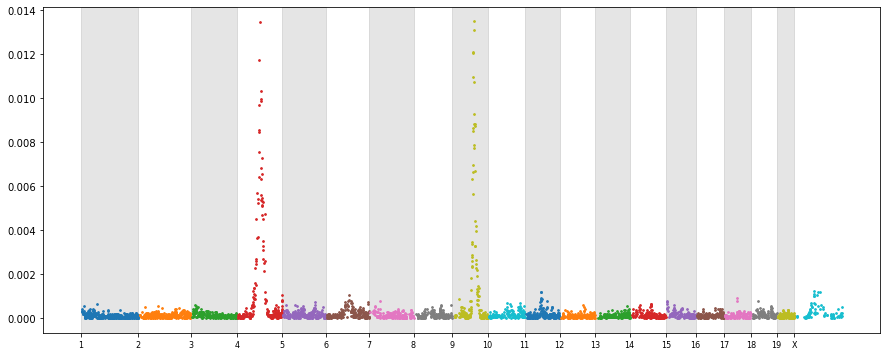

In [7]:
plt.figure(figsize=(15,6))
x_position = []
x_label = []
position = 0
for label, d in geno_meta.groupby("Chr", sort=False):
    x_position.append(position)
    x_label.append(label)
    plt.scatter(d['Mb']+position, d['importance'],s=3, zorder=2)
    position+=d['Mb'].max()
    
for x1, x2 in zip(x_position[::2], x_position[1::2]):
    plt.axvspan(x1, x2, color='black', alpha=0.1, zorder=1)

plt.xticks(x_position, x_label, fontsize=8)
plt.show()

### 2.3: Evaluate the model

If you took the effort to create a random forest, you might as well evaluate its performance.

* Calculate a cross-validated accuracy score
* Create a confusion matrix for the four colors using `sklearn.metrics.confusion_matrix` or `pd.crosstab`. You can lower the number of trees used by an order of magnitude (say, down to 100), since cross-validation makes things more time intensive.

In [8]:
cross_val_score(rf, data, target, cv=StratifiedKFold(3)).mean()

0.8444444444444444

In [9]:
prob = cross_val_predict(rf, data, target, cv=StratifiedKFold(3))
pd.crosstab(target, prob)

col_0,0.0,1.0,2.0,3.0
color,,,,
0.0,28,1,1,0
1.0,2,21,0,0
2.0,5,0,11,2
3.0,0,2,1,16


### 2.4: Show the optimal decision tree

It looks like coat color is determined by two SNPs, one on chromosome 4 and one on chromosome 9. Create and visualize a decision tree that classifies coat color based on these two SNPs. You can reduce the dataset to the most important SNPs in either chromosome, and train a not-so-random "forest" with a single tree (or use a decision tree directly).

In [10]:
data2 = data.loc[:,geno_meta.sort_values(by='importance', ascending=False)[:2].index]
# geno_meta = geno_meta.sort_values(by='importance')


In [11]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(data2, target)

RandomForestClassifier(n_estimators=1000)

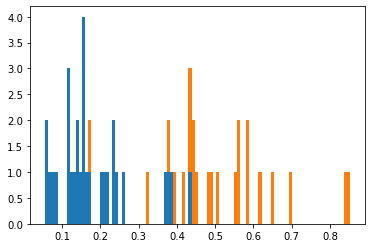

In [12]:
# Calculate confidence interval
internal_pred = cross_val_predict(rf, data, target, cv=StratifiedKFold(n_splits=3, shuffle=True), method='predict_proba')
internal_pred_hfd = pd.Series(internal_pred[:,1], index=data.index)

# plot hisgram
plt.hist([internal_pred_hfd.loc[target==0], internal_pred_hfd.loc[target==1]], histtype='barstacked', bins=100)
plt.show()

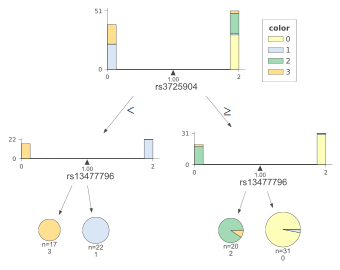

In [13]:
from dtreeviz.trees import dtreeviz
a_decision_tree = rf.estimators_[5]
dtreeviz(a_decision_tree, data2, target, feature_names=data2.columns, target_name="color", class_names=[0,1,2,3])

In [14]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(data, target)

RandomForestClassifier(n_estimators=1000)

In [15]:
colors = []
for i in target:
    if i == 0:
        colors.append('b')
    elif i == 1:
        colors.append('orange')
    elif i == 2:
        colors.append('red')
    else:
        colors.append('green')
index = ['b','orange','red','green']  

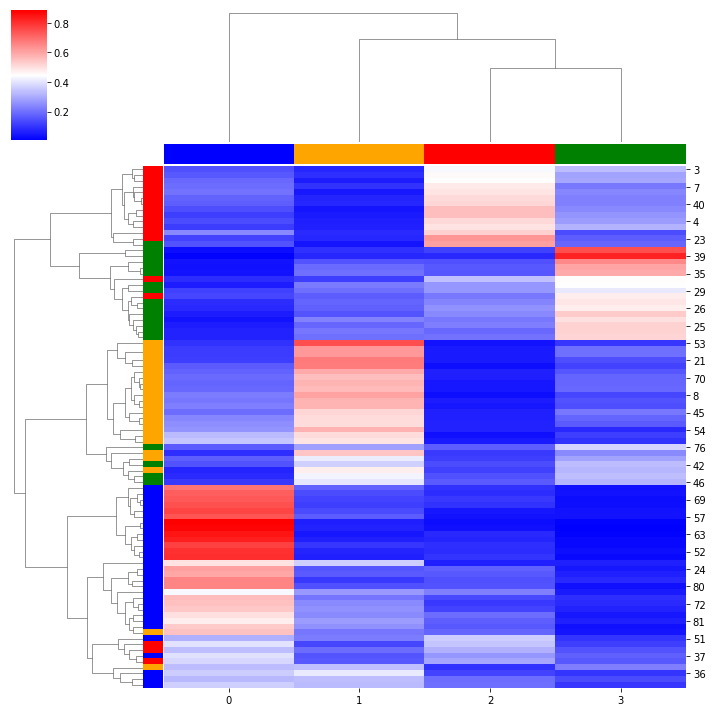

In [16]:
import seaborn as sns
color_prob = cross_val_predict(rf, data, target, cv=StratifiedKFold(n_splits=3, shuffle=True), method='predict_proba')
sns.clustermap(color_prob, cmap='bwr', row_colors=colors, col_colors=index)